<a href="https://colab.research.google.com/github/anirudh-g/Msc-Data-science/blob/master/Chart_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<H1> SETUP </H1>

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np

Using TensorFlow backend.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#7 classes: Area chart, Bar chart, Line Chart, pie chart, scatter plot. 100 images per class. 80/20 train/val split
train_dir = '/content/drive/My Drive/Colab Notebooks/charts/Train'
validation_dir = '/content/drive/My Drive/Colab Notebooks/charts/Validation'


<H1>BASELINE MODEL</H1>

In [4]:
#List of all basic tunable parameters of the model - to be updated
img_width, img_height = 224, 224
nb_train_samples = 560
nb_validation_samples = 140
epochs = 100
batch_size = 16

In [5]:
#checking whether the rgb channel is first or last to feed the input shape accordingly
if K.image_data_format() == 'channels_first': 
    input_shape = (3, img_width, img_height) 
else: 
    input_shape = (img_width, img_height, 3) 

In [6]:
#Performing augmentation on image scaling, zoom and fliiping the images horizontally so that the network has more training samples
train_datagen = ImageDataGenerator( 
	rescale=1. / 255, 
	shear_range=0.2, 
	zoom_range=0.2) 

#Not having any augmentation apart from scaling as the validation data should resemble the real-world data as close as possible
val_datagen = ImageDataGenerator(rescale=1. / 255) 

train_generator = train_datagen.flow_from_directory( 
	train_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical') 

validation_generator = val_datagen.flow_from_directory( 
	validation_dir, 
	target_size=(img_width, img_height), 
	batch_size=batch_size, 
	class_mode='categorical')

Found 560 images belonging to 7 classes.
Found 140 images belonging to 7 classes.


In [7]:
sample_training_images, _ = next(train_generator)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

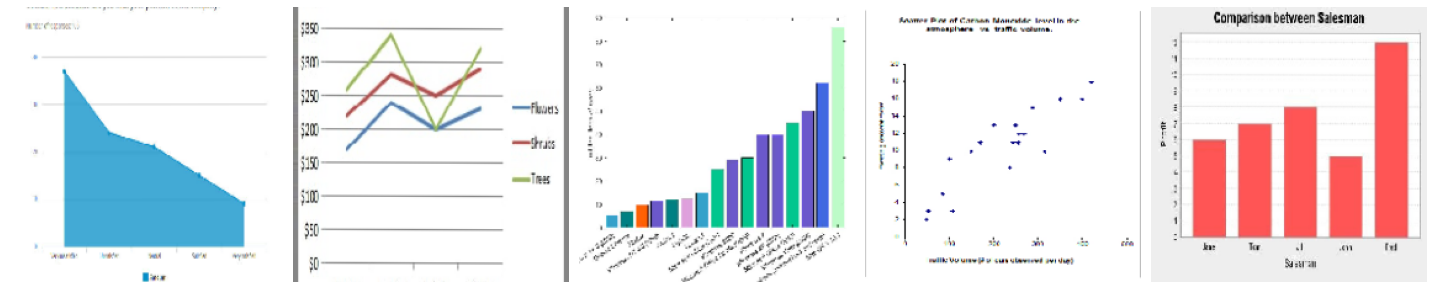

In [8]:
plotImages(sample_training_images[:5])

TRANSFER LEARNING

MOBILENETV2 - transfer learning

In [13]:
base_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________________________________________________________

In [14]:
base_model.trainable=False

In [15]:
x=base_model.output
x=GlobalAveragePooling2D()(x)
x=Dense(1024,activation='relu')(x) #we add dense layers so that the model can learn more complex functions and classify for better results.
x=Dense(1024,activation='relu')(x) #dense layer 2
x=Dense(512,activation='relu')(x) #dense layer 3
preds=Dense(7,activation='softmax')(x) #final layer with softmax activation
tl_model = keras.Model(inputs= base_model.input, outputs=preds)

In [16]:
tl_model.compile(optimizer='rmsprop',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

tl_history = tl_model.fit( 
	train_generator, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=100, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size) 


Epoch 1/100
35/35 [==============================] - 12s 329ms/step - loss: 1.3508 - accuracy: 0.6661 - val_loss: 0.2954 - val_accuracy: 0.9141
Epoch 2/100
35/35 [==============================] - 11s 309ms/step - loss: 0.3395 - accuracy: 0.8929 - val_loss: 0.2069 - val_accuracy: 0.9062
Epoch 3/100
35/35 [==============================] - 11s 319ms/step - loss: 0.2146 - accuracy: 0.9464 - val_loss: 0.1803 - val_accuracy: 0.9609
Epoch 4/100
35/35 [==============================] - 11s 306ms/step - loss: 0.2538 - accuracy: 0.9321 - val_loss: 0.1894 - val_accuracy: 0.9453
Epoch 5/100
35/35 [==============================] - 11s 304ms/step - loss: 0.1270 - accuracy: 0.9839 - val_loss: 0.4118 - val_accuracy: 0.9141
Epoch 6/100
35/35 [==============================] - 10s 299ms/step - loss: 0.1269 - accuracy: 0.9661 - val_loss: 0.1871 - val_accuracy: 0.9375
Epoch 7/100
35/35 [==============================] - 11s 301ms/step - loss: 0.0959 - accuracy: 0.9786 - val_loss: 0.3460 - val_accuracy:

VGG KERAS - transfer learning

In [22]:
base_model_2 = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
base_model_2.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [23]:
base_model_2.trainable=False

In [24]:
x2=base_model_2.output
x2=GlobalAveragePooling2D()(x2)
x2=Dense(1024,activation='relu')(x2) #we add dense layers so that the model can learn more complex functions and classify for better results.
x2=Dense(1024,activation='relu')(x2) #dense layer 2
x2=Dense(512,activation='relu')(x2) #dense layer 3
preds2=Dense(7,activation='softmax')(x2) #final layer with softmax activation
tl_model_2 = keras.Model(inputs= base_model_2.input, outputs=preds2)

In [25]:
tl_model_2.compile(optimizer='rmsprop',
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])

tl_history_2 = tl_model_2.fit( 
	train_generator, 
	steps_per_epoch=nb_train_samples // batch_size, 
	epochs=100, 
	validation_data=validation_generator, 
	validation_steps=nb_validation_samples // batch_size) 

Epoch 1/100
35/35 [==============================] - 12s 338ms/step - loss: 1.4505 - accuracy: 0.4661 - val_loss: 0.5871 - val_accuracy: 0.8281
Epoch 2/100
35/35 [==============================] - 12s 341ms/step - loss: 0.5518 - accuracy: 0.8018 - val_loss: 0.6231 - val_accuracy: 0.7344
Epoch 3/100
35/35 [==============================] - 12s 342ms/step - loss: 0.3798 - accuracy: 0.8839 - val_loss: 0.2710 - val_accuracy: 0.9219
Epoch 4/100
35/35 [==============================] - 12s 341ms/step - loss: 0.2859 - accuracy: 0.9089 - val_loss: 0.2482 - val_accuracy: 0.9375
Epoch 5/100
35/35 [==============================] - 12s 341ms/step - loss: 0.1961 - accuracy: 0.9339 - val_loss: 1.3116 - val_accuracy: 0.7578
Epoch 6/100
35/35 [==============================] - 12s 341ms/step - loss: 0.3177 - accuracy: 0.9196 - val_loss: 0.3076 - val_accuracy: 0.9219
Epoch 7/100
35/35 [==============================] - 12s 338ms/step - loss: 0.1303 - accuracy: 0.9661 - val_loss: 0.3204 - val_accuracy: